In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    return img, label

Num GPUs Available:  1


In [2]:
img_height = 224
img_width = 224

epoch = 50
batch_size = 32

base_dir = r'C:\Users\Szymon\101_split'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

5724
821
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
# AlexNet
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
    ])

filepath = 'cnn_model.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    mode='min')

# AlexNet
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 48)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 48)      192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 48)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      27712     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)       

In [4]:
train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch,
    callbacks = [checkpoint]
)

print(time.perf_counter()-start_time)

Epoch 1/50
178/178 [==============================] - 51s 242ms/step - loss: 4.7758 - accuracy: 0.1984 - val_loss: 3.5959 - val_accuracy: 0.3500

Epoch 00001: val_loss improved from inf to 3.59593, saving model to cnn_model.hdf5
Epoch 2/50
178/178 [==============================] - 43s 240ms/step - loss: 3.3367 - accuracy: 0.3160 - val_loss: 2.6414 - val_accuracy: 0.4500

Epoch 00002: val_loss improved from 3.59593 to 2.64140, saving model to cnn_model.hdf5
Epoch 3/50
178/178 [==============================] - 42s 239ms/step - loss: 2.6772 - accuracy: 0.4006 - val_loss: 2.3469 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 2.64140 to 2.34690, saving model to cnn_model.hdf5
Epoch 4/50
178/178 [==============================] - 42s 237ms/step - loss: 2.3256 - accuracy: 0.4598 - val_loss: 1.8374 - val_accuracy: 0.5550

Epoch 00004: val_loss improved from 2.34690 to 1.83735, saving model to cnn_model.hdf5
Epoch 5/50
178/178 [==============================] - 42s 238ms/step - l


Epoch 00039: val_loss did not improve from 0.87027
Epoch 40/50
178/178 [==============================] - 42s 236ms/step - loss: 0.2730 - accuracy: 0.9199 - val_loss: 1.0255 - val_accuracy: 0.7950

Epoch 00040: val_loss did not improve from 0.87027
Epoch 41/50
178/178 [==============================] - 42s 236ms/step - loss: 0.2332 - accuracy: 0.9280 - val_loss: 1.0212 - val_accuracy: 0.8000

Epoch 00041: val_loss did not improve from 0.87027
Epoch 42/50
178/178 [==============================] - 42s 236ms/step - loss: 0.2094 - accuracy: 0.9345 - val_loss: 1.1217 - val_accuracy: 0.7950

Epoch 00042: val_loss did not improve from 0.87027
Epoch 43/50
178/178 [==============================] - 42s 236ms/step - loss: 0.2200 - accuracy: 0.9294 - val_loss: 1.2301 - val_accuracy: 0.7550

Epoch 00043: val_loss did not improve from 0.87027
Epoch 44/50
178/178 [==============================] - 42s 235ms/step - loss: 0.2265 - accuracy: 0.9321 - val_loss: 1.1671 - val_accuracy: 0.7700

Epoch 000

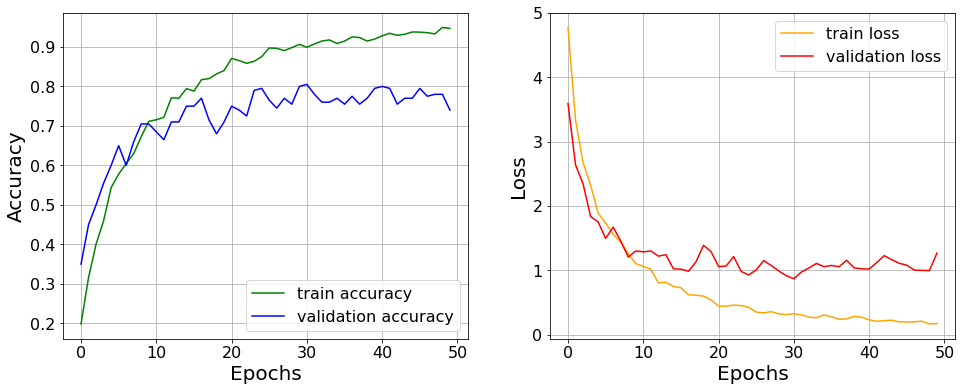

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validation accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validation loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [6]:
# 7Net

"""
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()
"""

'\ndata_augmentation = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    layers.experimental.preprocessing.RandomFlip(\'horizontal\'),\n    layers.experimental.preprocessing.RandomRotation(0.2),\n    layers.experimental.preprocessing.RandomContrast(0.1),\n    layers.experimental.preprocessing.RandomZoom(0.1)\n    ])\n\nmodel = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    #data_augmentation,\n    \n    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),\n    layers.Dropout(0.1),\n    \n    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),\n    layers.Dropout(0.2),\n    \n    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),\n    layers.Batch

In [5]:
# Alexnet
"""
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    #data_augmentation,
    
    layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()
"""

'\ndata_augmentation = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    layers.experimental.preprocessing.RandomFlip(\'horizontal\'),\n    layers.experimental.preprocessing.RandomRotation(0.2),\n    layers.experimental.preprocessing.RandomContrast(0.1),\n    layers.experimental.preprocessing.RandomZoom(0.1)\n    ])\n\n# AlexNet\nmodel = tf.keras.Sequential([\n    layers.InputLayer(input_shape=(img_height, img_width, 3)),\n    #data_augmentation,\n    \n    layers.Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),\n    \n    layers.Conv2D(filters=256, kernel_size=(5,5),strides=(1,1),padding="same", activation="relu"),\n    layers.BatchNormalization(),\n    layers.MaxPool2D(pool_size=(3,3),strides=(2,2)),\n    \n    layers.Conv2D(filters=384, kernel_size=(3,3),strides=(1,1),padding="same", activation="relu"),\n    layers.Ba